# Time series forecasting For Beer 

# Initial setup

## Import required packages

In [77]:
import pandas as pd 
import numpy as np 
from pylab import rcParams
import statsmodels.api as sm
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from scipy.stats import boxcox
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import pmdarima as pm
from statsmodels.graphics.tsaplots import plot_pacf
%matplotlib inline
from statsmodels.graphics.tsaplots import plot_pacf
import warnings
warnings.filterwarnings("ignore")

## Import time series data : Monthly Beer Production 

In [78]:
data = pd.read_csv('beer.csv', header = None)
data.columns = data.iloc[0]

# Remove the first row from the data
data = data[1:]
#Set period data as index 
data['Month'] = pd.to_datetime(data['Month'], format='%Y-%m')
data = data.set_index('Month')
data

,Monthly beer production
Month,
1956-01-01,93.2
1956-02-01,96
1956-03-01,95.2
1956-04-01,77.1
1956-05-01,70.9
...,...
1995-04-01,127
1995-05-01,151
1995-06-01,130


In [79]:
data

,Monthly beer production
Month,
1956-01-01,93.2
1956-02-01,96
1956-03-01,95.2
1956-04-01,77.1
1956-05-01,70.9
...,...
1995-04-01,127
1995-05-01,151
1995-06-01,130


In [80]:
#Changing columns naame Monthly beer production to beer for ease purpose and setting dtype as float 
data = data.rename(columns={"Monthly beer production": "beer"})
data.columns
data["beer"] = data["beer"].astype(float)

# Time series analysis

## Plot time series data

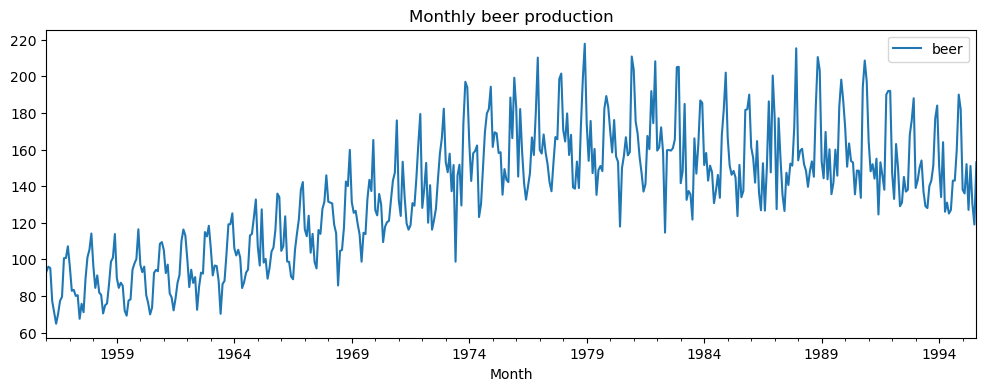

In [81]:
data.plot(figsize=(12, 4))
plt.legend(loc='best')
plt.title('Monthly beer production')
plt.show(block=False)

In [82]:
#Looking at the graph, we can see that there is seasonality of 12 and a trend.

## Missing value treatment

### Mean imputation

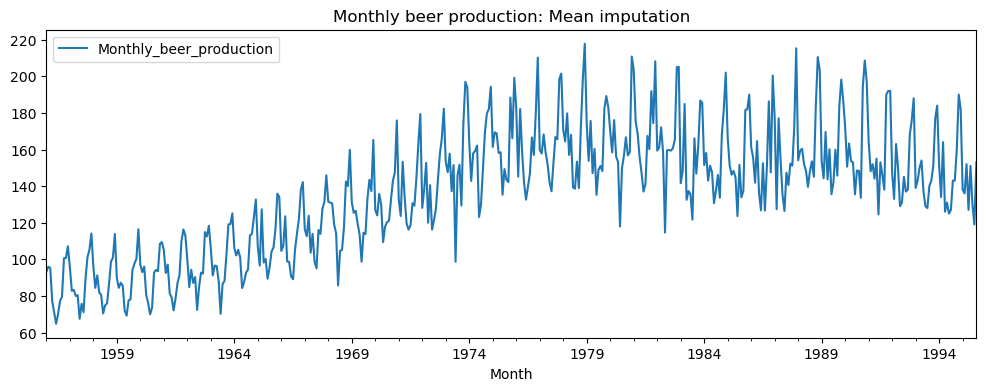

In [83]:
data = data.assign(Monthly_beer_production=data.beer.fillna(data.beer.mean()))
data[['Monthly_beer_production']].plot(figsize=(12, 4))
plt.legend(loc='best')
plt.title('Monthly beer production: Mean imputation')
plt.show(block=False)

### Linear interpolation

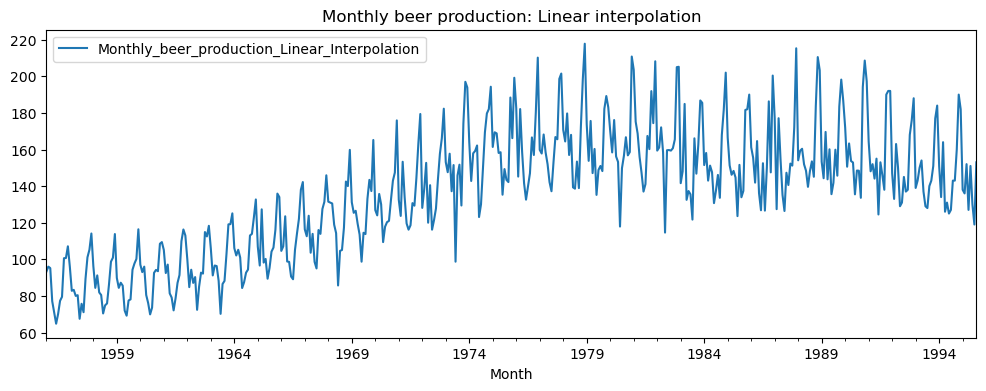

In [84]:
data = data.assign(Monthly_beer_production_Linear_Interpolation=data.beer.interpolate(method='linear'))
data[['Monthly_beer_production_Linear_Interpolation']].plot(figsize=(12, 4))
plt.legend(loc='best')
plt.title('Monthly beer production: Linear interpolation')
plt.show(block=False)

### Use linear interpolation to impute missing values

In [85]:
data['beer'] = data['Monthly_beer_production_Linear_Interpolation']
data.drop(columns=['Monthly_beer_production','Monthly_beer_production_Linear_Interpolation'],inplace=True)

## Outlier detection

### Box plot and interquartile range

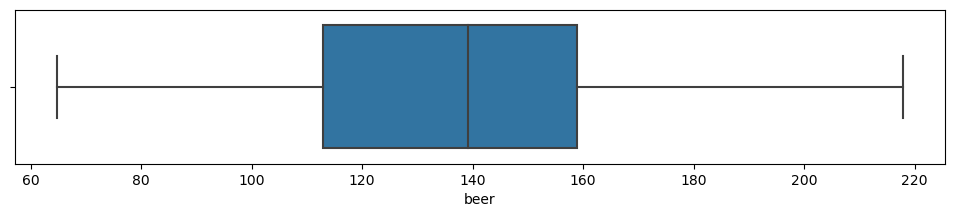

In [86]:

fig = plt.subplots(figsize=(12, 2))
ax = sns.boxplot(x=data['beer'],whis=1.5)

In [87]:
# Q1 = np.percentile(data['beer'], 25,
#                    interpolation = 'midpoint')
 
# Q3 = np.percentile(data['beer'], 75,
#                    interpolation = 'midpoint')
# IQR = Q3 - Q1
 
# print("Old Shape: ", data.shape)
 
# # Upper bound
# upper = np.where(data['beer'] >= (Q3+1.5*IQR))
# # Lower bound
# lower = np.where(data['beer'] <= (Q1-1.5*IQR))
 
# ''' Removing the Outliers '''
# data.drop(upper[0], inplace = True)
# data.drop(lower[0], inplace = True)
# print("new Shape: ", data.shape)
 

### Histogram plot

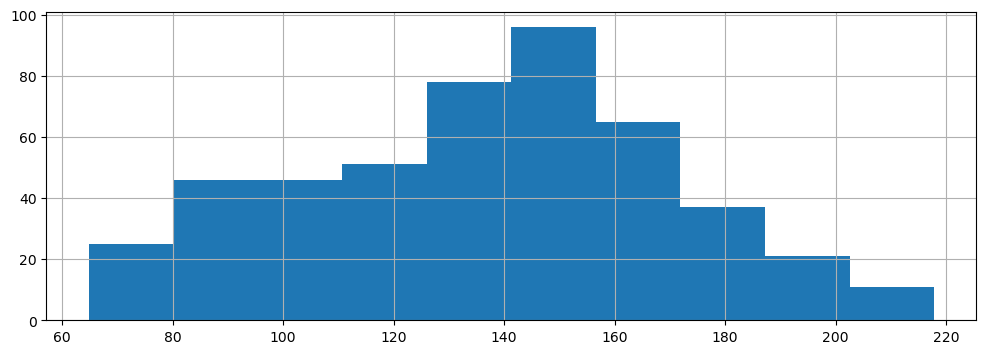

In [88]:
fig = data.beer.hist(figsize = (12,4))

## Time series Decomposition

### Additive seasonal decomposition

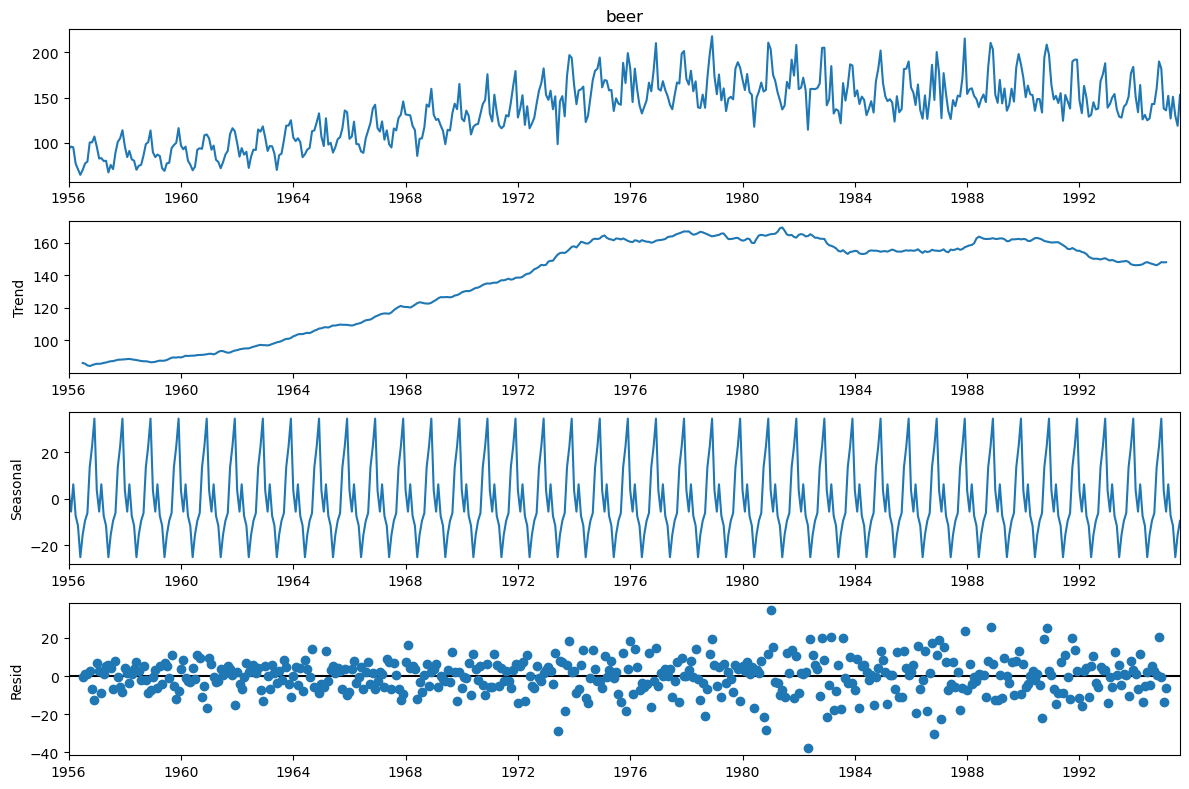

In [89]:

rcParams['figure.figsize'] = 12, 8
decomposition = sm.tsa.seasonal_decompose(data.beer, model='additive') # additive seasonal index
fig = decomposition.plot()
plt.show()

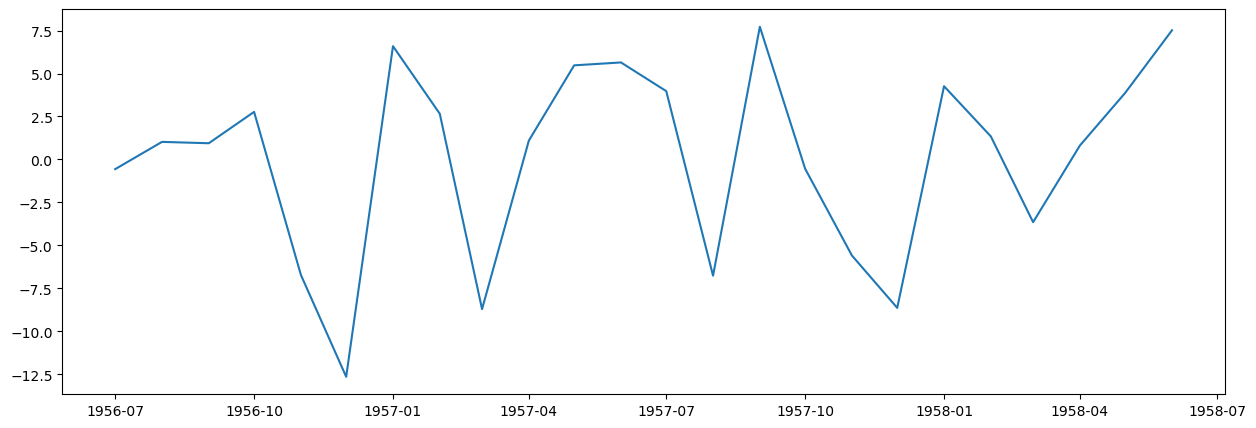

In [90]:
residual = decomposition.resid
plt.figure(figsize=(15,5))
plt.plot(residual.dropna(inplace=False).head(24),label='Residuals')

# Build and evaluate time series forecast

## Split time series data into training and test set

In [91]:
train_len = 300
train = data[0:train_len] 
test = data[train_len:] 

# Simple time series methods

## Naive method

In [92]:
y_hat_naive = test.copy()
y_hat_naive['naive_forecast'] = train['beer'][train_len-1]

### Plot train, test and forecast

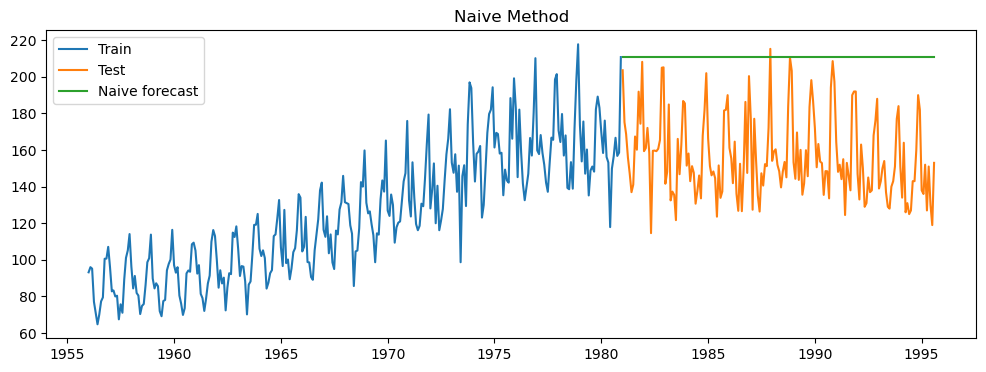

In [93]:
plt.figure(figsize=(12,4))
plt.plot(train['beer'], label='Train')
plt.plot(test['beer'], label='Test')
plt.plot(y_hat_naive['naive_forecast'], label='Naive forecast')
plt.legend(loc='best')
plt.title('Naive Method')
plt.show()

### Calculate RMSE and MAPE

In [94]:

rmse = np.sqrt(mean_squared_error(test['beer'], y_hat_naive['naive_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['beer']-y_hat_naive['naive_forecast'])/test['beer'])*100,2)

results = pd.DataFrame({'Method':['Naive method'], 'MAPE': [mape], 'RMSE': [rmse]})
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,58.83,37.5


## Simple average method

In [95]:
y_hat_avg = test.copy()
y_hat_avg['avg_forecast'] = train['beer'].mean()

### Plot train, test and forecast

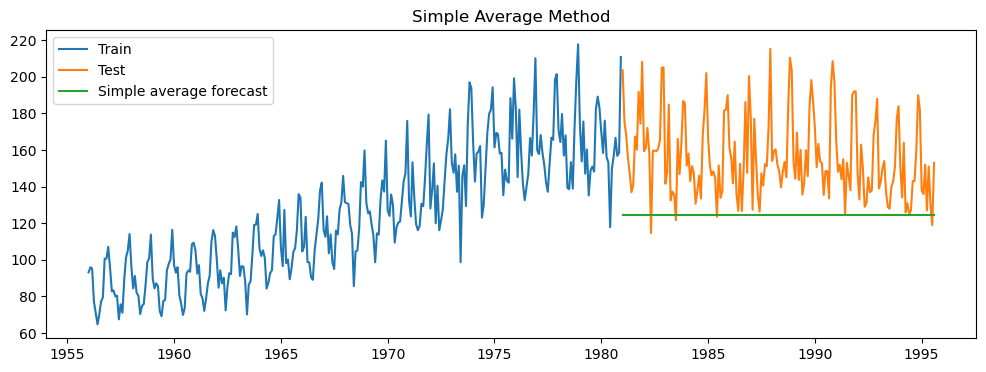

In [96]:
plt.figure(figsize=(12,4))
plt.plot(train['beer'], label='Train')
plt.plot(test['beer'], label='Test')
plt.plot(y_hat_avg['avg_forecast'], label='Simple average forecast')
plt.legend(loc='best')
plt.title('Simple Average Method')
plt.show()

### Calculate RMSE and MAPE

In [97]:
rmse = np.sqrt(mean_squared_error(test['beer'], y_hat_avg['avg_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['beer']-y_hat_avg['avg_forecast'])/test['beer'])*100,2)

tempResults = pd.DataFrame({'Method':['Simple average method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,58.83,37.50
0,Simple average method,38.38,18.83


## Simple moving average method

In [98]:
y_hat_sma = data.copy()
ma_window = 12
y_hat_sma['sma_forecast'] = data['beer'].rolling(ma_window).mean()
y_hat_sma['sma_forecast'][train_len:] = y_hat_sma['sma_forecast'][train_len-1]

### Plot train, test and forecast

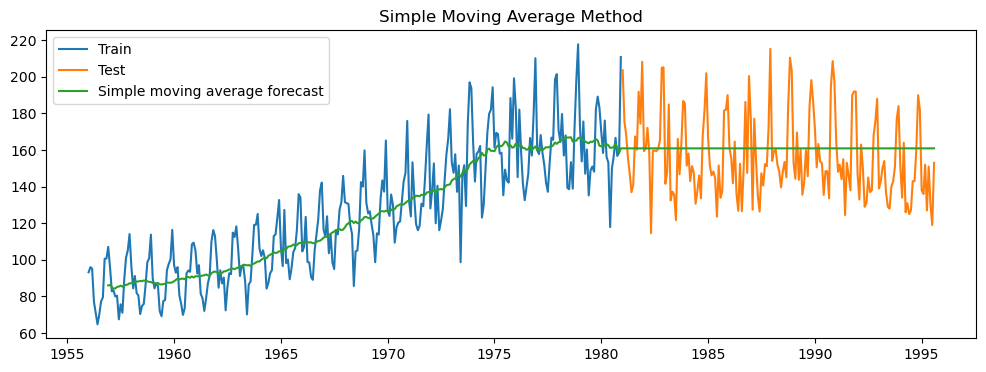

In [99]:
plt.figure(figsize=(12,4))
plt.plot(train['beer'], label='Train')
plt.plot(test['beer'], label='Test')
plt.plot(y_hat_sma['sma_forecast'], label='Simple moving average forecast')
plt.legend(loc='best')
plt.title('Simple Moving Average Method')
plt.show()

### Calculate RMSE and MAPE

In [100]:
rmse = np.sqrt(mean_squared_error(test['beer'], y_hat_sma['sma_forecast'][train_len:])).round(2)
mape = np.round(np.mean(np.abs(test['beer']-y_hat_sma['sma_forecast'][train_len:])/test['beer'])*100,2)

tempResults = pd.DataFrame({'Method':['Simple moving average forecast'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,58.83,37.50
0,Simple average method,38.38,18.83
0,Simple moving average forecast,22.48,12.29


# Exponential smoothing methods

## Simple exponential smoothing

In [101]:

model = SimpleExpSmoothing(train['beer'])
model_fit = model.fit(smoothing_level=0.02,optimized=False)
model_fit.params
y_hat_ses = test.copy()
y_hat_ses['ses_forecast'] = model_fit.forecast(1000)


### Plot train, test and forecast

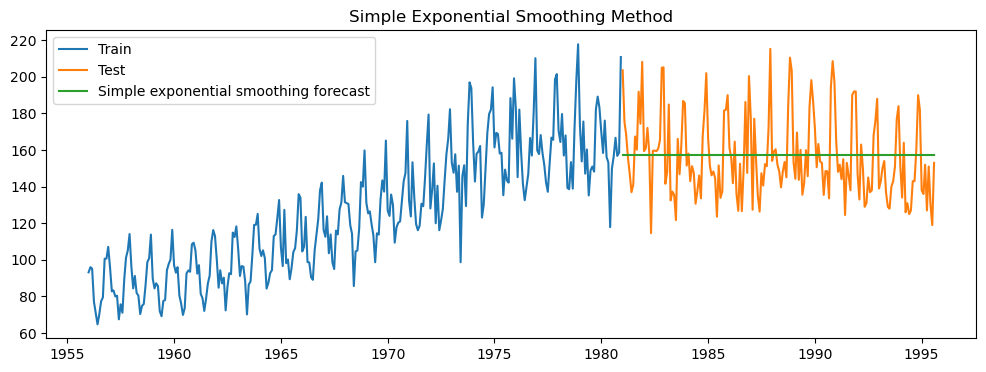

In [102]:
plt.figure(figsize=(12,4))
plt.plot(train['beer'], label='Train')
plt.plot(test['beer'], label='Test')
plt.plot(y_hat_ses['ses_forecast'], label='Simple exponential smoothing forecast')
plt.legend(loc='best')
plt.title('Simple Exponential Smoothing Method')
plt.show()

### Calculate RMSE and MAPE

In [103]:
rmse = np.sqrt(mean_squared_error(test['beer'], y_hat_ses['ses_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['beer']-y_hat_ses['ses_forecast'])/test['beer'])*100,2)

tempResults = pd.DataFrame({'Method':['Simple exponential smoothing forecast'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results

,Method,RMSE,MAPE
0,Naive method,58.83,37.50
0,Simple average method,38.38,18.83
0,Simple moving average forecast,22.48,12.29
0,Simple exponential smoothing forecast,22.01,11.45


## Holt's method with trend

In [104]:

model = ExponentialSmoothing(np.asarray(train['beer']) ,seasonal_periods=12 ,trend='additive', seasonal=None)
model_fit = model.fit(smoothing_level=0.02, smoothing_slope=0.25, optimized=False)
print(model_fit.params)
y_hat_holt = test.copy()
y_hat_holt['holt_forecast'] = model_fit.forecast(len(test))

{'smoothing_level': 0.02, 'smoothing_trend': 0.25, 'smoothing_seasonal': None, 'damping_trend': nan, 'initial_level': 87.98666666666662, 'initial_trend': -1.003030303030299, 'initial_seasons': array([], dtype=float64), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


### Plot train, test and forecast

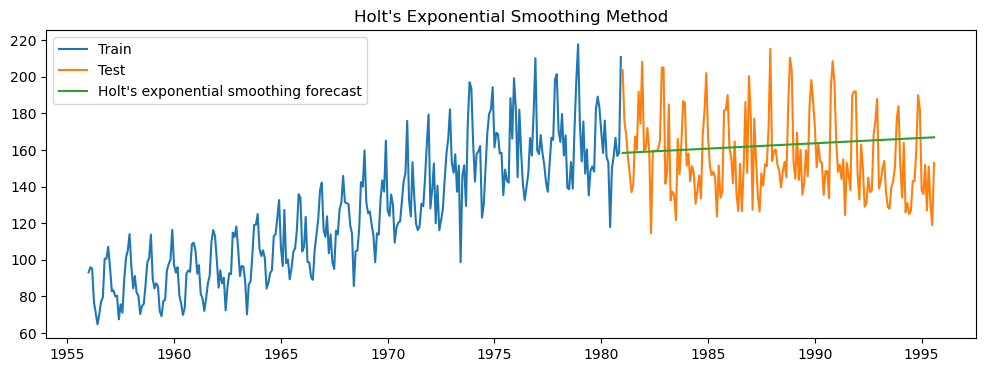

In [105]:
plt.figure(figsize=(12,4))
plt.plot( train['beer'], label='Train')
plt.plot(test['beer'], label='Test')
plt.plot(y_hat_holt['holt_forecast'], label='Holt\'s exponential smoothing forecast')
plt.legend(loc='best')
plt.title('Holt\'s Exponential Smoothing Method')
plt.show()

### Calculate RSME and MAPE

In [106]:
rmse = np.sqrt(mean_squared_error(test['beer'], y_hat_holt['holt_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['beer']-y_hat_holt['holt_forecast'])/test['beer'])*100,2)

tempResults = pd.DataFrame({'Method':['Holt\'s exponential smoothing method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,58.83,37.50
0,Simple average method,38.38,18.83
0,Simple moving average forecast,22.48,12.29
0,Simple exponential smoothing forecast,22.01,11.45
0,Holt's exponential smoothing method,23.48,13.11


## Holt Winters' additive method with trend and seasonality

In [107]:
y_hat_hwa = test.copy()
model = ExponentialSmoothing(np.asarray(train['beer']) ,seasonal_periods=12 ,trend='add', seasonal='add')
model_fit = model.fit(optimized=True)
print(model_fit.params)
y_hat_hwa['hw_forecast'] = model_fit.forecast(176)

{'smoothing_level': 0.07202749829394196, 'smoothing_trend': 0.07202749828437312, 'smoothing_seasonal': 0.12568556683873772, 'damping_trend': nan, 'initial_level': 86.08825322088946, 'initial_trend': 0.0056416146272938485, 'initial_seasons': array([  5.87494577,  -1.41482379,   4.96179114,  -7.11665114,
       -10.87245003, -22.01436651, -14.44697184,  -8.96234123,
        -0.77882275,  12.19395655,  17.30401284,  26.27044853]), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


### Plot train, test and forecast

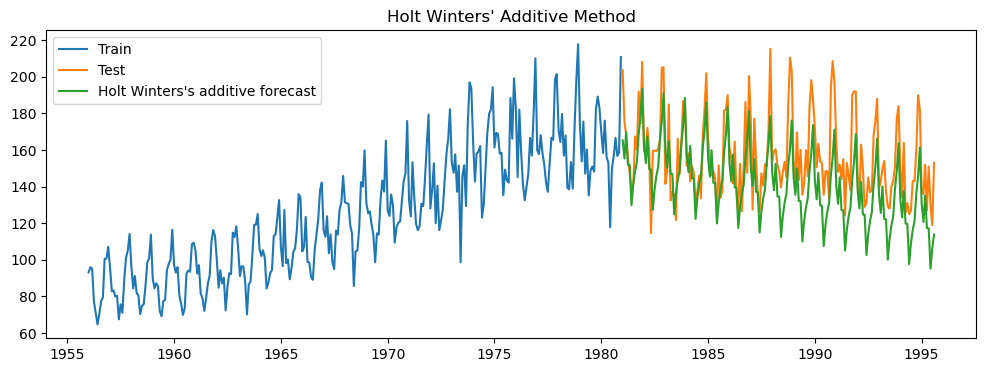

In [108]:
plt.figure(figsize=(12,4))
plt.plot( train['beer'], label='Train')
plt.plot(test['beer'], label='Test')
plt.plot(y_hat_hwa['hw_forecast'], label='Holt Winters\'s additive forecast')
plt.legend(loc='best')
plt.title('Holt Winters\' Additive Method')
plt.show()

### Calculate RMSE and MAPE

In [109]:
rmse = np.sqrt(mean_squared_error(test['beer'], y_hat_hwa['hw_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['beer']-y_hat_hwa['hw_forecast'])/test['beer'])*100,2)

tempResults = pd.DataFrame({'Method':['Holt Winters\' additive method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,58.83,37.50
0,Simple average method,38.38,18.83
0,Simple moving average forecast,22.48,12.29
0,Simple exponential smoothing forecast,22.01,11.45
0,Holt's exponential smoothing method,23.48,13.11
0,Holt Winters' additive method,20.48,10.91


## Holt Winter's multiplicative method with trend and seasonality

In [110]:
y_hat_hwm = test.copy()
model = ExponentialSmoothing(np.asarray(train['beer']) ,seasonal_periods=12 ,trend='add', seasonal='mul')
model_fit = model.fit(optimized=True)
print(model_fit.params)
y_hat_hwm['hw_forecast'] = model_fit.forecast(176)

{'smoothing_level': 0.08531341880483793, 'smoothing_trend': 0.06946181033008927, 'smoothing_seasonal': 0.0, 'damping_trend': nan, 'initial_level': 51.94440218887565, 'initial_trend': 0.06825340385145995, 'initial_seasons': array([1.70623389, 1.60136215, 1.75132977, 1.55905929, 1.53985915,
       1.31893039, 1.43699989, 1.5237926 , 1.60141047, 1.78461026,
       1.88532692, 2.05939251]), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


### Plot train, test and forecast

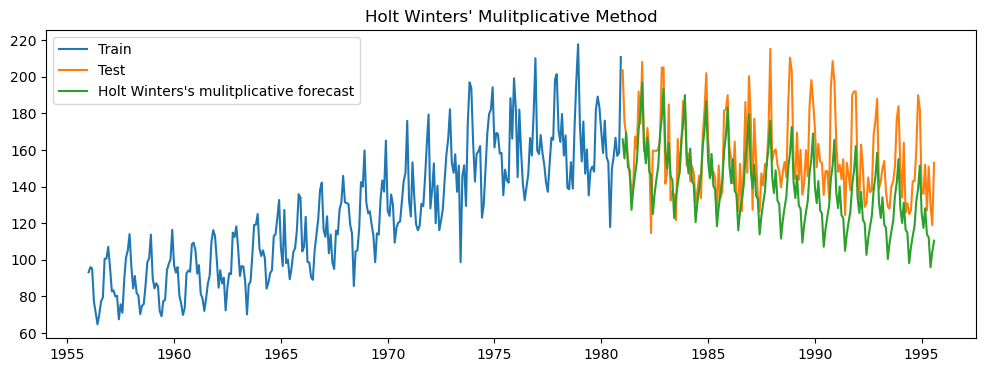

In [111]:
plt.figure(figsize=(12,4))
plt.plot( train['beer'], label='Train')
plt.plot(test['beer'], label='Test')
plt.plot(y_hat_hwm['hw_forecast'], label='Holt Winters\'s mulitplicative forecast')
plt.legend(loc='best')
plt.title('Holt Winters\' Mulitplicative Method')
plt.show()

### Calculate RMSE and MAPE

In [112]:
rmse = np.sqrt(mean_squared_error(test['beer'], y_hat_hwm['hw_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['beer']-y_hat_hwm['hw_forecast'])/test['beer'])*100,2)

tempResults = pd.DataFrame({'Method':['Holt Winters\' multiplicative method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,58.83,37.50
0,Simple average method,38.38,18.83
0,Simple moving average forecast,22.48,12.29
0,Simple exponential smoothing forecast,22.01,11.45
0,Holt's exponential smoothing method,23.48,13.11
0,Holt Winters' additive method,20.48,10.91
0,Holt Winters' multiplicative method,22.50,12.14


# Auto Regressive methods

## Stationarity vs non-stationary time series

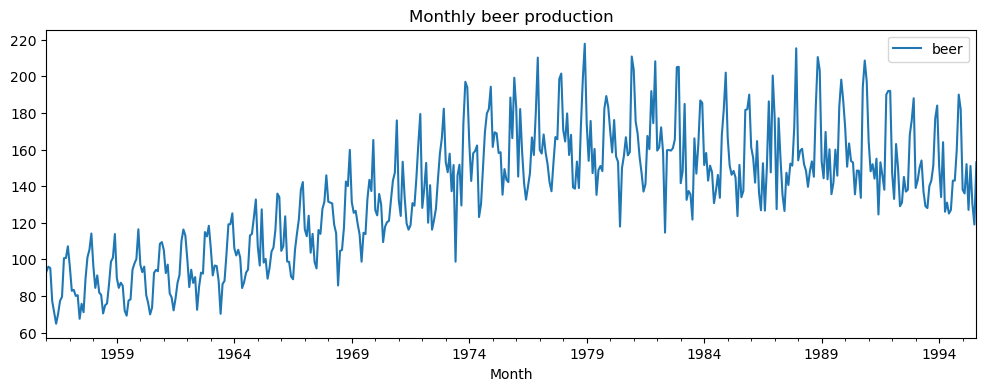

In [113]:
data['beer'].plot(figsize=(12, 4))
plt.legend(loc='best')
plt.title('Monthly beer production')
plt.show(block=False)

### Augmented Dickey-Fuller (ADF) test

In [114]:

adf_test = adfuller(data['beer'])

print('ADF Statistic: %f' % adf_test[0])
print('Critical Values @ 0.05: %.2f' % adf_test[4]['5%'])
print('p-value: %f' % adf_test[1])

ADF Statistic: -2.282661
Critical Values @ 0.05: -2.87
p-value: 0.177621


### Box Cox transformation to make variance constant

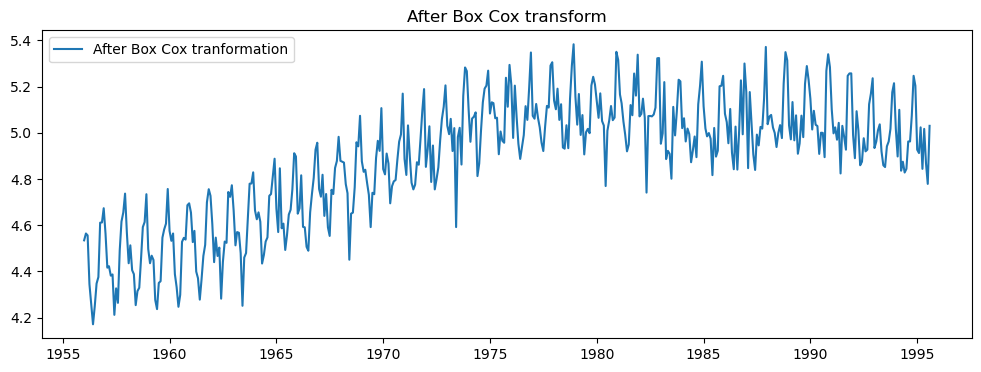

In [115]:

data_boxcox = pd.Series(boxcox(data['beer'], lmbda=0), index = data.index)

plt.figure(figsize=(12,4))
plt.plot(data_boxcox, label='After Box Cox tranformation')
plt.legend(loc='best')
plt.title('After Box Cox transform')
plt.show()

### Differencing to remove trend

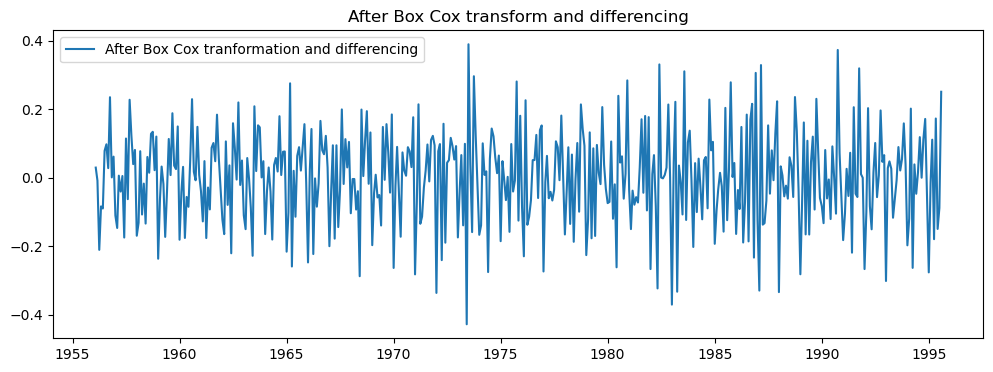

In [116]:
data_boxcox_diff = pd.Series(data_boxcox - data_boxcox.shift(), data.index)
plt.figure(figsize=(12,4))
plt.plot(data_boxcox_diff, label='After Box Cox tranformation and differencing')
plt.legend(loc='best')
plt.title('After Box Cox transform and differencing')
plt.show()

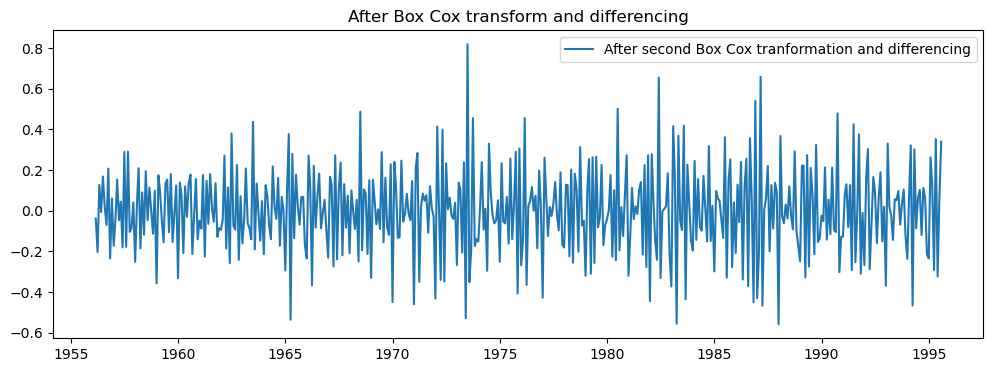

In [117]:
data_boxcox_diff = pd.Series(data_boxcox_diff - data_boxcox_diff.shift(), data.index)
plt.figure(figsize=(12,4))
plt.plot(data_boxcox_diff, label='After second Box Cox tranformation and differencing')
plt.legend(loc='best')
plt.title('After Box Cox transform and differencing')
plt.show()

In [118]:
data_boxcox_diff.dropna(inplace=True)

In [119]:
data_boxcox_diff.tail()

Month
1995-04-01   -0.290919
1995-05-01    0.352786
1995-06-01   -0.322838
1995-07-01    0.061334
1995-08-01    0.339725
Name: beer, dtype: float64

### Augmented Dickey-Fuller (ADF) test

In [120]:
adf_test = adfuller(data_boxcox_diff)

print('ADF Statistic: %f' % adf_test[0])
print('Critical Values @ 0.05: %.2f' % adf_test[4]['5%'])
print('p-value: %f' % adf_test[1])

ADF Statistic: -14.580776
Critical Values @ 0.05: -2.87
p-value: 0.000000


## Autocorrelation function (ACF)

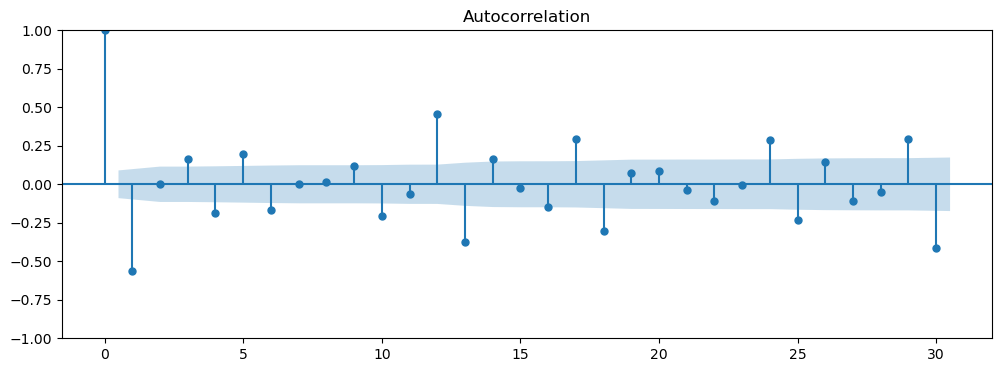

In [121]:

plt.figure(figsize=(12,4))
plot_acf(data_boxcox_diff, ax=plt.gca(), lags = 30)
plt.show()

## Partial autocorrelation function (PACF)

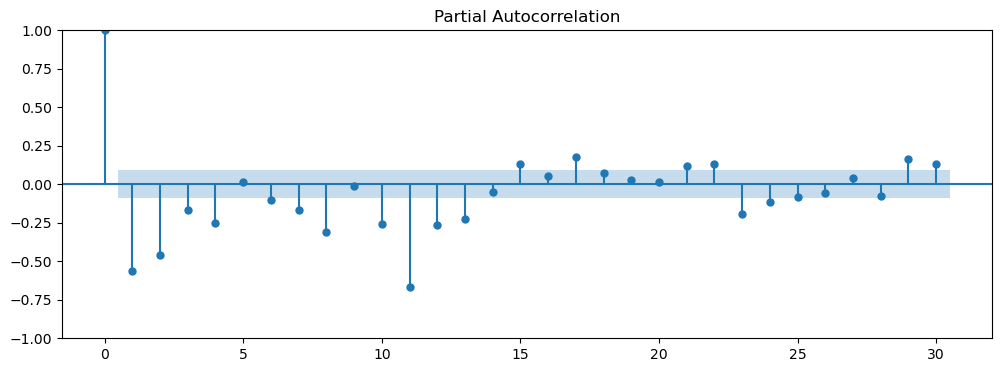

In [122]:

plt.figure(figsize=(12,4))
plot_pacf(data_boxcox_diff, ax=plt.gca(), lags = 30)
plt.show()

In [123]:
train_data_boxcox = data_boxcox[:train_len]
test_data_boxcox = data_boxcox[train_len:]
train_data_boxcox_diff = data_boxcox_diff[:train_len-1]
test_data_boxcox_diff = data_boxcox_diff[train_len-1:]

In [124]:
train_data_boxcox_diff

Month
1956-03-01   -0.037969
1956-04-01   -0.202508
1956-05-01    0.127044
1956-06-01   -0.006132
1956-07-01    0.168582
                ...   
1980-09-01    0.018107
1980-10-01   -0.123726
1980-11-01    0.072639
1980-12-01    0.273110
1981-01-01   -0.319277
Name: beer, Length: 299, dtype: float64

## Seasonal auto regressive integrated moving average (SARIMA)

In [125]:
# !pip install pmdarima

In [156]:
model = SARIMAX(train_data_boxcox, order=(5,1, 4), seasonal_order=(5, 1, 6, 12)) 
model_fit = model.fit()
# p÷rint(model_fit.params)
print(model_fit.summary())

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           21     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.16619D+00    |proj g|=  1.36688D+00

At iterate    5    f= -1.23957D+00    |proj g|=  2.96567D+00

At iterate   10    f= -1.28160D+00    |proj g|=  1.68015D+00

At iterate   15    f= -1.32947D+00    |proj g|=  3.19995D-01

At iterate   20    f= -1.33816D+00    |proj g|=  5.17469D-02

At iterate   25    f= -1.34335D+00    |proj g|=  4.71901D-01

At iterate   30    f= -1.34679D+00    |proj g|=  4.40585D-01

At iterate   35    f= -1.34863D+00    |proj g|=  1.98082D-01

At iterate   40    f= -1.34940D+00    |proj g|=  4.69904D-02

At iterate   45    f= -1.35008D+00    |proj g|=  6.98446D-02

At iterate   50    f= -1.35140D+00    |proj g|=  6.14987D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

### Recover original time series forecast

In [157]:
y_hat_sarima = data_boxcox_diff.copy()
y_hat_sarima['sarima_forecast_boxcox'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_sarima['sarima_forecast'] = np.exp(y_hat_sarima['sarima_forecast_boxcox'])

### Plot train, test and forecast

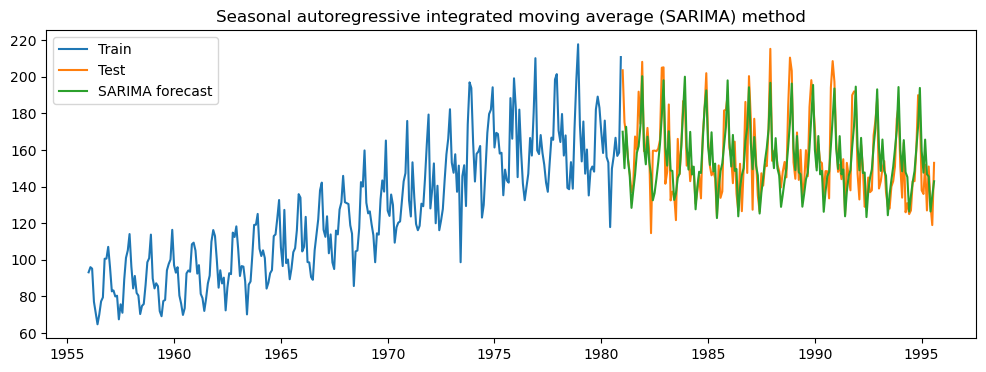

In [158]:
plt.figure(figsize=(12,4))
plt.plot(train['beer'], label='Train')
plt.plot(test['beer'], label='Test')
plt.plot(y_hat_sarima['sarima_forecast'][test.index.min():], label='SARIMA forecast')
plt.legend(loc='best')
plt.title('Seasonal autoregressive integrated moving average (SARIMA) method')
plt.show()

### Calculate RMSE and MAPE

In [155]:
rmse = np.sqrt(mean_squared_error(test['beer'], y_hat_sarima['sarima_forecast'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['beer']-y_hat_sarima['sarima_forecast'][test.index.min():])/test['beer'])*100,2)

tempResults = pd.DataFrame({'Method':['Seasonal autoregressive integrated moving average (SARIMA) method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,58.83,37.50
0,Simple average method,38.38,18.83
0,Simple moving average forecast,22.48,12.29
0,Simple exponential smoothing forecast,22.01,11.45
0,Holt's exponential smoothing method,23.48,13.11
0,Holt Winters' additive method,20.48,10.91
0,Holt Winters' multiplicative method,22.50,12.14
0,Seasonal autoregressive integrated moving aver...,13.24,6.64
0,Seasonal autoregressive integrated moving aver...,14.20,6.83
0,Seasonal autoregressive integrated moving aver...,14.77,7.14


<AxesSubplot:xlabel='Month'>

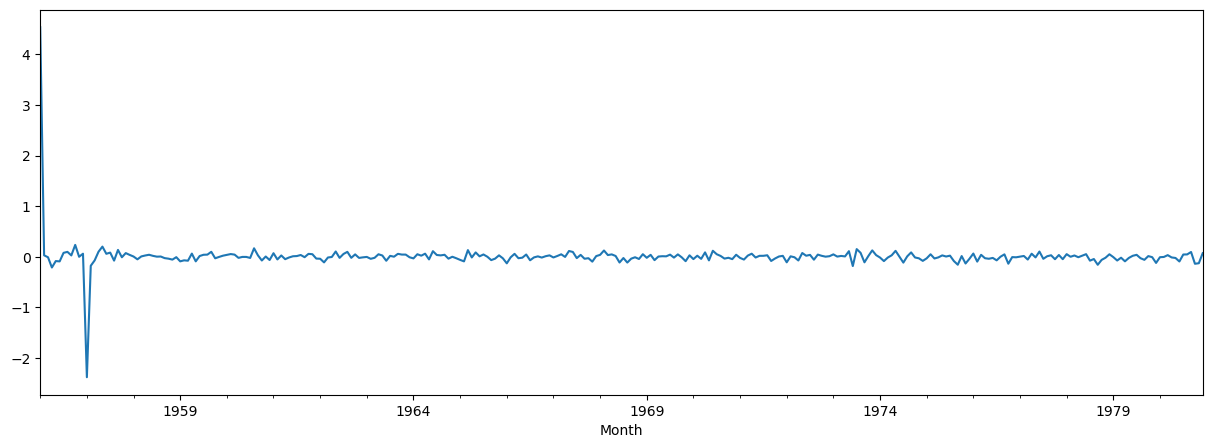

In [133]:
plt.figure(figsize=(15,5))
model_fit.resid.plot()

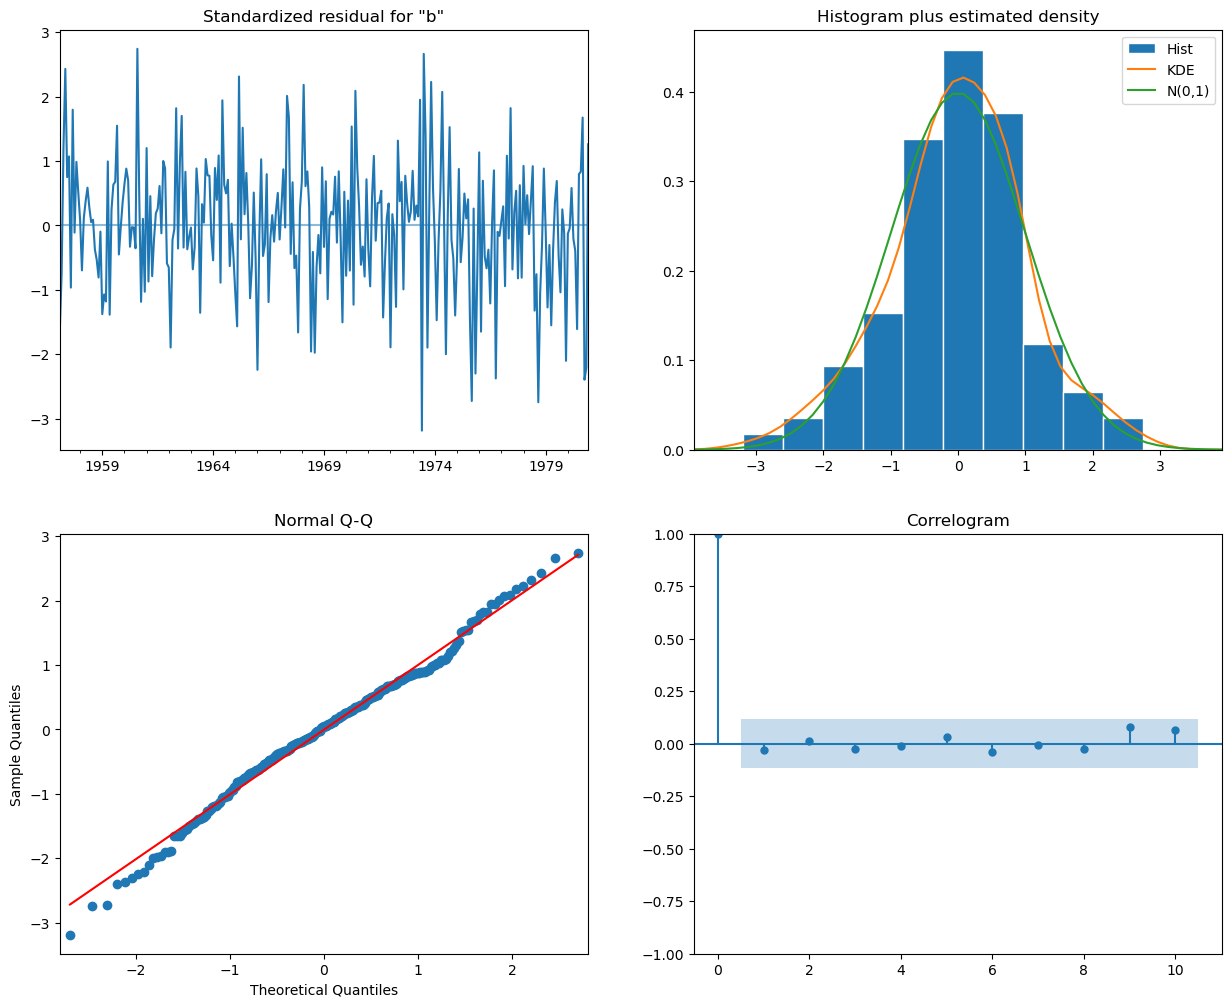

In [134]:
model_fit.plot_diagnostics(figsize=(15, 12))
plt.show()

In [135]:

forecast = model_fit.get_forecast(steps=250)

forecast_ci = forecast.conf_int()
forecast_ci.tail(200)

,lower beer,upper beer
1985-03-01,4.923446,5.354845
1985-04-01,4.784076,5.220907
1985-05-01,4.797889,5.238828
1985-06-01,4.613561,5.059352
1985-07-01,4.708224,5.159307
...,...,...
2001-06-01,3.705783,5.920415
2001-07-01,3.777306,6.003438
2001-08-01,3.833524,6.070517
2001-09-01,3.857200,6.105605


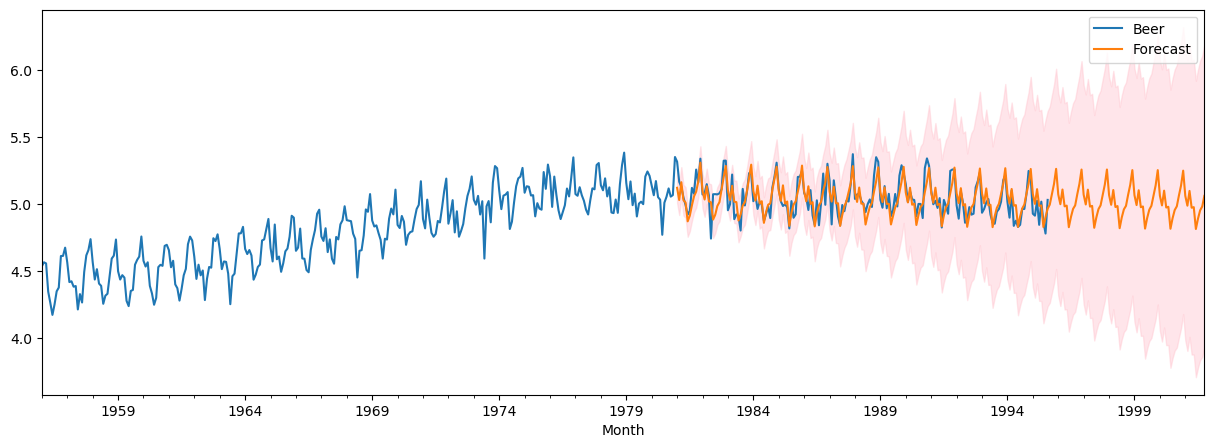

In [136]:
beer_prediction_range = data_boxcox.plot(label='Beer', figsize=(15, 5))
forecast.predicted_mean.plot(ax=beer_prediction_range, label='Forecast')
beer_prediction_range.fill_between(forecast_ci.index,
                forecast_ci.iloc[:, 0],
                forecast_ci.iloc[:, 1], color='pink', alpha=.4)


plt.legend()
plt.show()